## Modality-specific object selectivity
This code examines the modality bias of PER single neurons. That is, neurons were classified into visually-biased, auditorily-biased, or unbiased categories. Temporal characteristics were compared between the categories

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt  

from datetime import date
import time

import h5py

In [3]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
mother_path = Path('D:/Multi-modal project/')
fig_path = mother_path / 'analysis' / 'result' / 'figures'

### Parameter setting

In [5]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['tab:blue','tab:red','tab:gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [6]:
# load hdf5 files containing shuffled results
data_path = mother_path /'analysis'/'result'/'3. ANOVA'/'2023-07-10'
data2_path = mother_path /'analysis'/'result'/'3.1 Multiple linear regression'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

In [7]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [8]:
df = h5_to_df(f2)
df = df[(df['region']=='PER')&(df['response cell']==0)]
df.reset_index(inplace=True,drop=True)

for key in df['key']:  
    
    df.loc[df['key']==key,'pref_obj'] = f[key].attrs['preferred object']
    df.loc[df['key']==key,'peak_selectivity'] = np.max(f[f'{key}/anova_eta'])  
    df.loc[df['key']==key,'peak_selectivity_time'] = f[key].attrs['peak selectivity time']
    df.loc[df['key']==key,'selectivity_duration'] = len(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_onset'] = np.min(f[f'{key}/object_bin'])*10
    df.loc[df['key']==key,'selectivity_index'] = f[key].attrs['selectivity index']
    df.loc[df['key']==key,'BG'] = f[key].attrs['BG']
    
    if f[key].attrs['preferred object'] == 'Boy':
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][3]
    else:
        df.loc[df['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df.loc[df['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df.loc[df['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df.loc[df['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
df['peak_selectivity_time_range'] = (df['peak_selectivity_time'] // 100) + 1        

### Classifying visual, auditory, and unbiased neurons

In [9]:
# classification based on permutation test (shuffling)
for i in range(len(df)):
    k = df.loc[i,'key']
    beta_diff = df.loc[i,'coef_pref_image']-df.loc[i,'coef_pref_sound']
    if df.loc[i,'pref_obj']=='Boy':
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])
    else:
        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,2],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,3])
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df.loc[i,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df.loc[i,'Category'] = 'auditory'
    else:
        df.loc[i,'Category'] = 'unbiased'

In [10]:
x = [sum(df['Category']=='visual'), sum(df['Category']=='auditory'), sum(df['Category']=='unbiased')]

print(f'Visual cell: {x[0]} / {np.sum(x)}')
print(f'Auditory cell: {x[1]} / {np.sum(x)}')
print(f'Unbiased cell: {x[2]} / {np.sum(x)}')

Visual cell: 21 / 149
Auditory cell: 27 / 149
Unbiased cell: 101 / 149


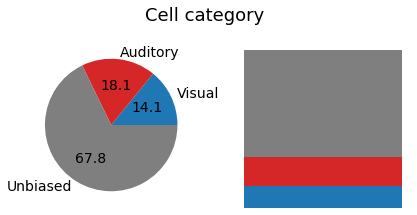

In [11]:
# proportion plot

fig,ax = plt.subplots(1,2,figsize=(6,3))

fig.suptitle('Cell category', fontsize=18)
ax[0].pie(x,colors=color,labels=['Visual','Auditory','Unbiased'],autopct='%.1f',textprops={'fontsize':14});
ax[1].axis('off')
prev_data = 0
for i in range(3):
    ax[1].bar(1, height = x[i], bottom=prev_data, color=color[i])
    prev_data += x[i]

plt.tight_layout()
#plt.savefig(fig_path / 'cell_porportion_pie_bar.png', dpi=300,facecolor='white')

### Modality-specific response patterns

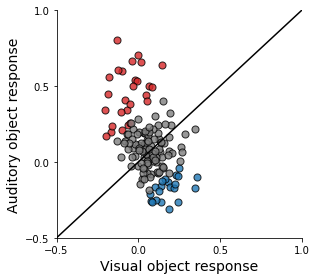

In [12]:
fig,ax = plt.subplots(figsize=(4.5,4))

gs = fig.add_gridspec(2,2, width_ratios=(4,1), height_ratios=(1,4))

#ax.scatter(df['coef_pref_image'],df['coef_pref_sound'], 
#           c = df['peak_selectivity_time_range'], cmap = 'viridis')
#norm = mpl.colors.Normalize(vmin=0,vmax=9)
#colormapping = mpl.cm.ScalarMappable(norm=norm,cmap=mpl.cm.viridis)
#fig.colorbar(colormapping, ax=plt.gca())

cat = ['visual','auditory','unbiased']
colors = ['tab:blue','tab:red','tab:gray']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'coef_pref_image']
    y = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax.scatter(x, y, facecolors=colors[c],edgecolors='k',alpha=0.8, s=50)

ax.plot(np.arange(-1,2.1,0.5),np.arange(-1,2.1,0.5),color='black')
ax.set_xticks(np.arange(-1,2.1,0.5));
ax.set_yticks(np.arange(-1,2.1,0.5));
ax.set_xlim([-0.5,1])
ax.set_ylim([-0.5,1])

#ax.set_xlabel('Coefficient for preferred image',fontsize=14);
#ax.set_ylabel('Coefficient for preferred sound',fontsize=14);

ax.set_xlabel('Visual object response',fontsize=14);
ax.set_ylabel('Auditory object response',fontsize=14);

plt.tight_layout()

#plt.savefig(fig_path / 'image_sound_scatter.png', dpi=300,facecolor='white')

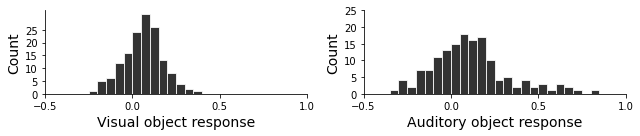

In [13]:
fig,ax = plt.subplots(1,2,figsize=(9,2))

x = ['coef_pref_image', 'coef_pref_sound']
xlabel = ['Visual object response', 'Auditory object response']

for i in range(2):
    ax[i].hist(df[x[i]], color='black', bins=np.arange(-0.5,1,0.05), alpha=0.8, ec='white');
    ax[i].set_xlabel(xlabel[i], fontsize=14);
    ax[i].set_xticks(np.arange(-0.5,1.5,0.5));
    ax[i].set_xlim([-0.5,1])
    ax[i].set_ylabel('Count', fontsize=14);
    ax[i].set_yticks(np.arange(0,30,5));

plt.tight_layout()
#plt.savefig(fig_path / 'image_sound_hist.png', dpi=300,facecolor='white')

In [14]:
pg.wilcoxon(df['coef_pref_image'],df['coef_pref_sound'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,4794.0,two-sided,0.132888,-0.142013,0.444484


### Temporal patterns of modality-specific response 

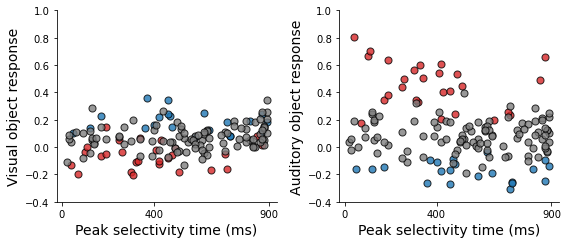

In [15]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'peak_selectivity_time']
    y = df.loc[df['Category']==cat[c],'coef_pref_image']        
    y2 = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax[0].scatter(x, y, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolors=color[c], edgecolors='k', alpha=0.8, s=50)

ylabel = ['Visual object response', 'Auditory object response']
for i in range(2):
    ax[i].set_xticks([0,400,900]);
    ax[i].set_xlabel('Peak selectivity time (ms)', fontsize=14);
    ax[i].set_yticks(np.arange(-0.4,1.2,0.2));
    ax[i].set_ylabel(ylabel[i], fontsize=14);

plt.tight_layout()
#plt.savefig(fig_path / 'coef_time_scatter.png', dpi=300,facecolor='white')

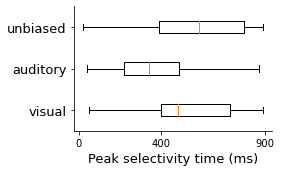

In [16]:
fig,ax = plt.subplots(figsize=(4,2.5))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'peak_selectivity_time'] for c in x]
ax.boxplot(y, vert=False);
ax.set_yticklabels(x, fontsize=13);
ax.set_xticks([0, 400, 900]);
ax.set_xlabel('Peak selectivity time (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_time_boxplot.png', dpi=300,facecolor='white')

In [17]:
pg.kruskal(data=df, dv='peak_selectivity_time', between='Category')

,Source,ddof1,H,p-unc
Kruskal,Category,2,9.124335,0.010439


In [18]:
import scikit_posthocs as sp

data = [df.loc[df['Category']=='visual','peak_selectivity_time'],
        df.loc[df['Category']=='auditory','peak_selectivity_time'],
        df.loc[df['Category']=='unbiased', 'peak_selectivity_time']]
kruskal_posthoc = sp.posthoc_dunn(data, p_adjust = 'simes-hochberg')
kruskal_posthoc

,1,2,3
1,1.000000,0.090861,0.772552
2,0.090861,1.000000,0.007921
3,0.772552,0.007921,1.000000


In [19]:
print(pg.mwu(y[0],y[1])['p-val']*3)
print(pg.mwu(y[0],y[2])['p-val']*3)
print(pg.mwu(y[1],y[2])['p-val']*3)

MWU    0.089388
Name: p-val, dtype: float64
MWU    2.180423
Name: p-val, dtype: float64
MWU    0.009622
Name: p-val, dtype: float64


### Selectivity duration and modality-specific response

In [20]:
lr_v = sm.OLS(df['coef_pref_image'],sm.add_constant(df['selectivity_duration'])).fit()
lr_a = sm.OLS(df['coef_pref_sound'],sm.add_constant(df['selectivity_duration'])).fit()

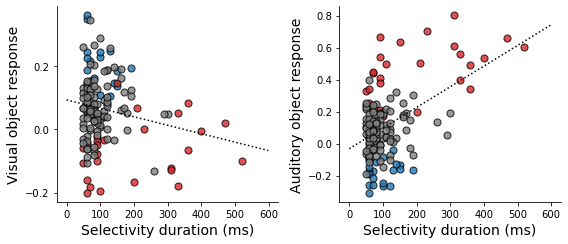

In [21]:
fig,ax = plt.subplots(1,2,figsize=(8,3.5))

cat = ['visual','auditory','unbiased']
for c in range(3):
    x = df.loc[df['Category']==cat[c],'selectivity_duration']
    y = df.loc[df['Category']==cat[c],'coef_pref_image']
    y2 = df.loc[df['Category']==cat[c],'coef_pref_sound']
    ax[0].scatter(x, y, facecolors=colors[c], edgecolors='k', alpha=0.8, s=50)
    ax[1].scatter(x, y2, facecolors=colors[c], edgecolors='k', alpha=0.8, s=50)
    
ylabel = ['Visual object response', 'Auditory object response']
for i in range(2):
    ax[i].set_xticks(np.arange(0,700,100));
    ax[i].set_xlabel('Selectivity duration (ms)', fontsize=14);
    ax[i].set_yticks(np.arange(-0.4,1.2,0.2));
    ax[i].set_ylabel(ylabel[i], fontsize=14);
    
x = np.arange(0,600,1)
ax[0].plot(x, x*lr_v.params[1]+lr_v.params[0], linestyle=':', color='black')
ax[1].plot(x, x*lr_a.params[1]+lr_a.params[0], linestyle=':', color='black')

plt.tight_layout()
#plt.savefig(fig_path / 'duration_coef_scatter.png', dpi=300,facecolor='white')

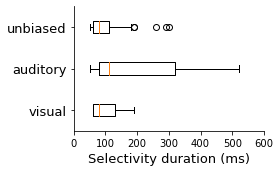

In [22]:
fig,ax = plt.subplots(figsize=(4,2.5))

x = ['visual','auditory','unbiased']
y = [df.loc[df['Category']==c,'selectivity_duration'] for c in x]
ax.boxplot(y, vert=False);
ax.set_yticklabels(x, fontsize=13);
ax.set_xticks(np.arange(0,700,100));
ax.set_xlabel('Selectivity duration (ms)', fontsize=13)

plt.tight_layout()
#plt.savefig(fig_path / 'category_duration_boxplot.png', dpi=300,facecolor='white')

In [23]:
pg.kruskal(data=df, dv='selectivity_duration', between='Category')

,Source,ddof1,H,p-unc
Kruskal,Category,2,10.024671,0.006655


In [24]:
data = [df.loc[df['Category']=='visual','selectivity_duration'],
        df.loc[df['Category']=='auditory','selectivity_duration'],
        df.loc[df['Category']=='unbiased', 'selectivity_duration']]
kruskal_posthoc = sp.posthoc_dunn(data, p_adjust = 'simes-hochberg')
kruskal_posthoc

,1,2,3
1,1.000000,0.102304,0.622423
2,0.102304,1.000000,0.004666
3,0.622423,0.004666,1.000000


### Anatomy and modality-specific categories

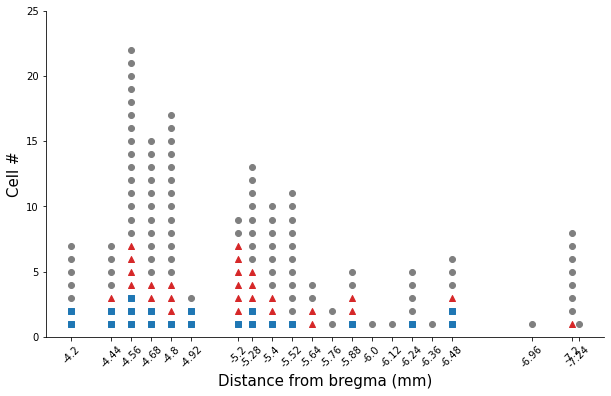

In [25]:
bg_dict = {bg : 1 for bg in np.sort(df['BG'].unique())}

fig,ax = plt.subplots(figsize=(10,6))

cat = ['visual','auditory','unbiased']
marker = ['s', '^', 'o']

for i in range(3):
    df_cat = df[df['Category']==cat[i]]
    df_cat.reset_index(inplace=True, drop=True)
    for j in range(len(df_cat)):
        bg = df_cat.loc[j,'BG']
        ax.scatter(bg, bg_dict[bg], color=color[i], marker=marker[i])
        bg_dict[bg] += 1
ax.set_yticks(np.arange(0,30,5));
ax.set_ylabel('Cell #',fontsize=15)
ax.set_xticks(np.sort(df['BG'].unique()))
ax.set_xticklabels(np.sort(df['BG'].unique())*-1)
ax.tick_params(axis='x',labelrotation=45)
ax.set_xlabel('Distance from bregma (mm)',fontsize=15);

plt.savefig(fig_path / 'anatomy_category_scatter.png', dpi=300,facecolor='white')